# Fuel Consumption Prediction

## Import Libraries

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm,skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [139]:
column_name=["MPG","Cylinders","Displacement","Horsepower","Weight","Acceleration","Model Year","Origin"]

In [140]:
data=pd.read_csv("auto-mpg.data",names=column_name,na_values="?",comment="\t",sep=" ",skipinitialspace=True)

In [141]:
data=data.rename(columns={"MPG":"target"})

In [142]:
data.head()

,target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [143]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
target,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [144]:
data.shape

(398, 8)

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


## Missing Value

<Axes: xlabel='Horsepower', ylabel='Density'>

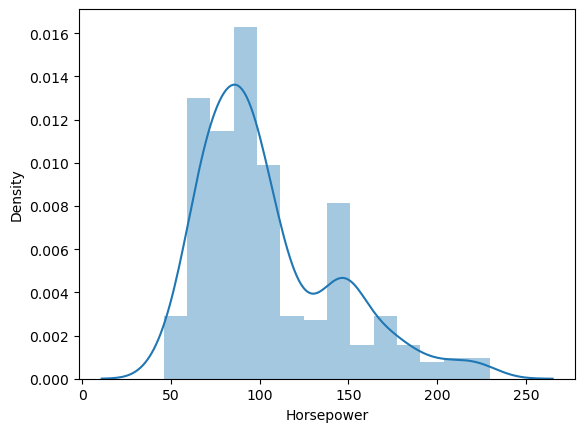

In [146]:
data["Horsepower"].fillna(data["Horsepower"].mean())
sns.distplot(data.Horsepower)

## EDA

In [147]:
corr_matrix=data.corr()

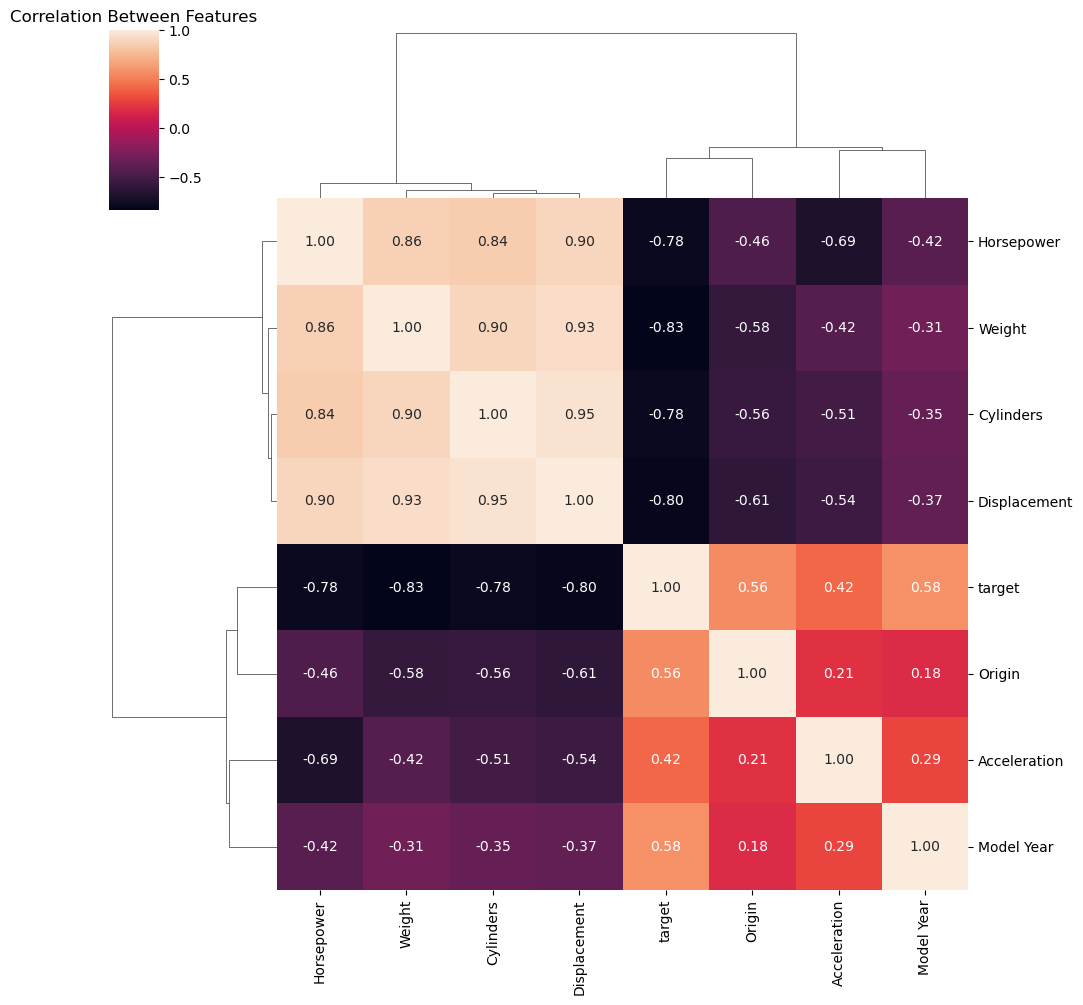

In [148]:
sns.clustermap(corr_matrix,annot=True,fmt=".2f")
plt.title("Correlation Between Features");

* The target feature has a strong negative correlation with the variables horsepower, weight, cylinder and displacement.
* Data has multicollinearity.

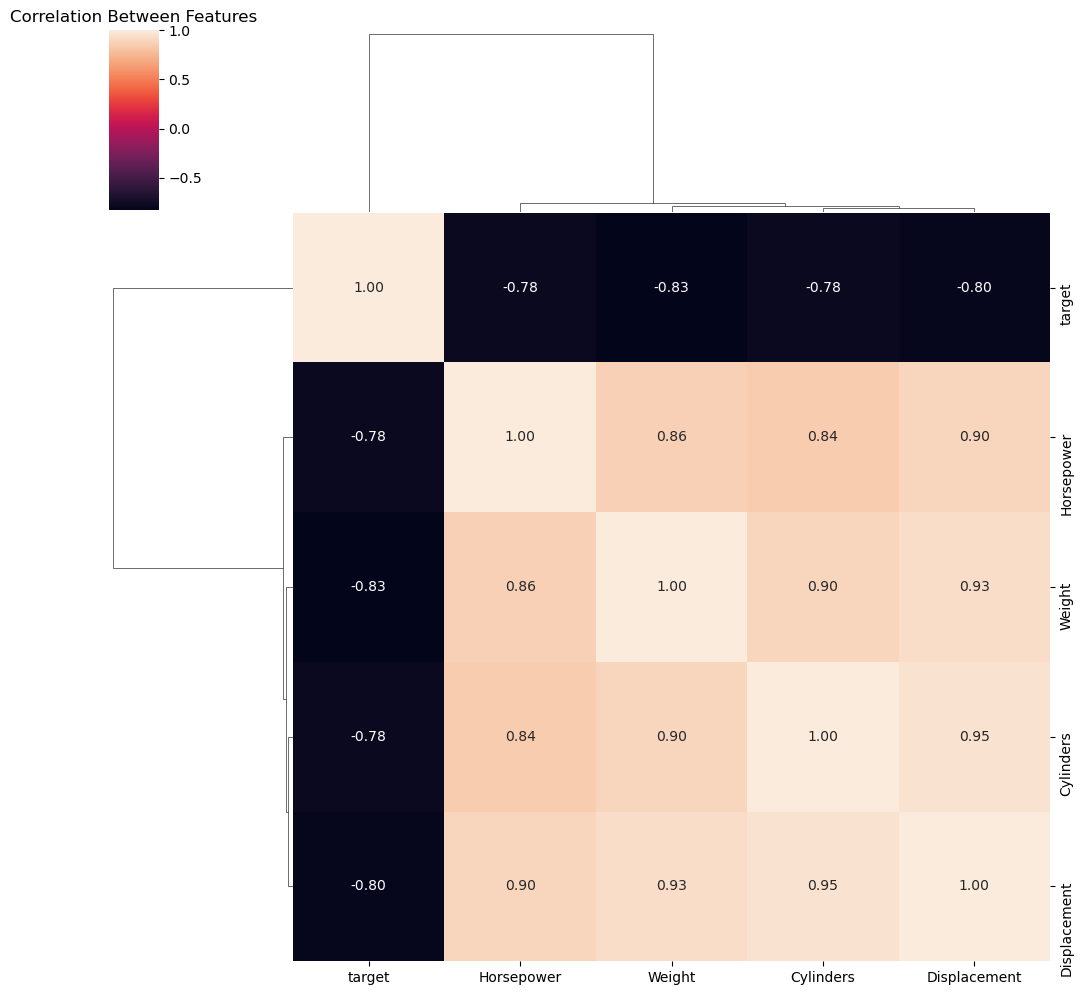

In [149]:
threshold=0.75
filtre=np.abs(corr_matrix["target"])>threshold
corr_features=corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(),annot=True,fmt=".2f")
plt.title("Correlation Between Features");

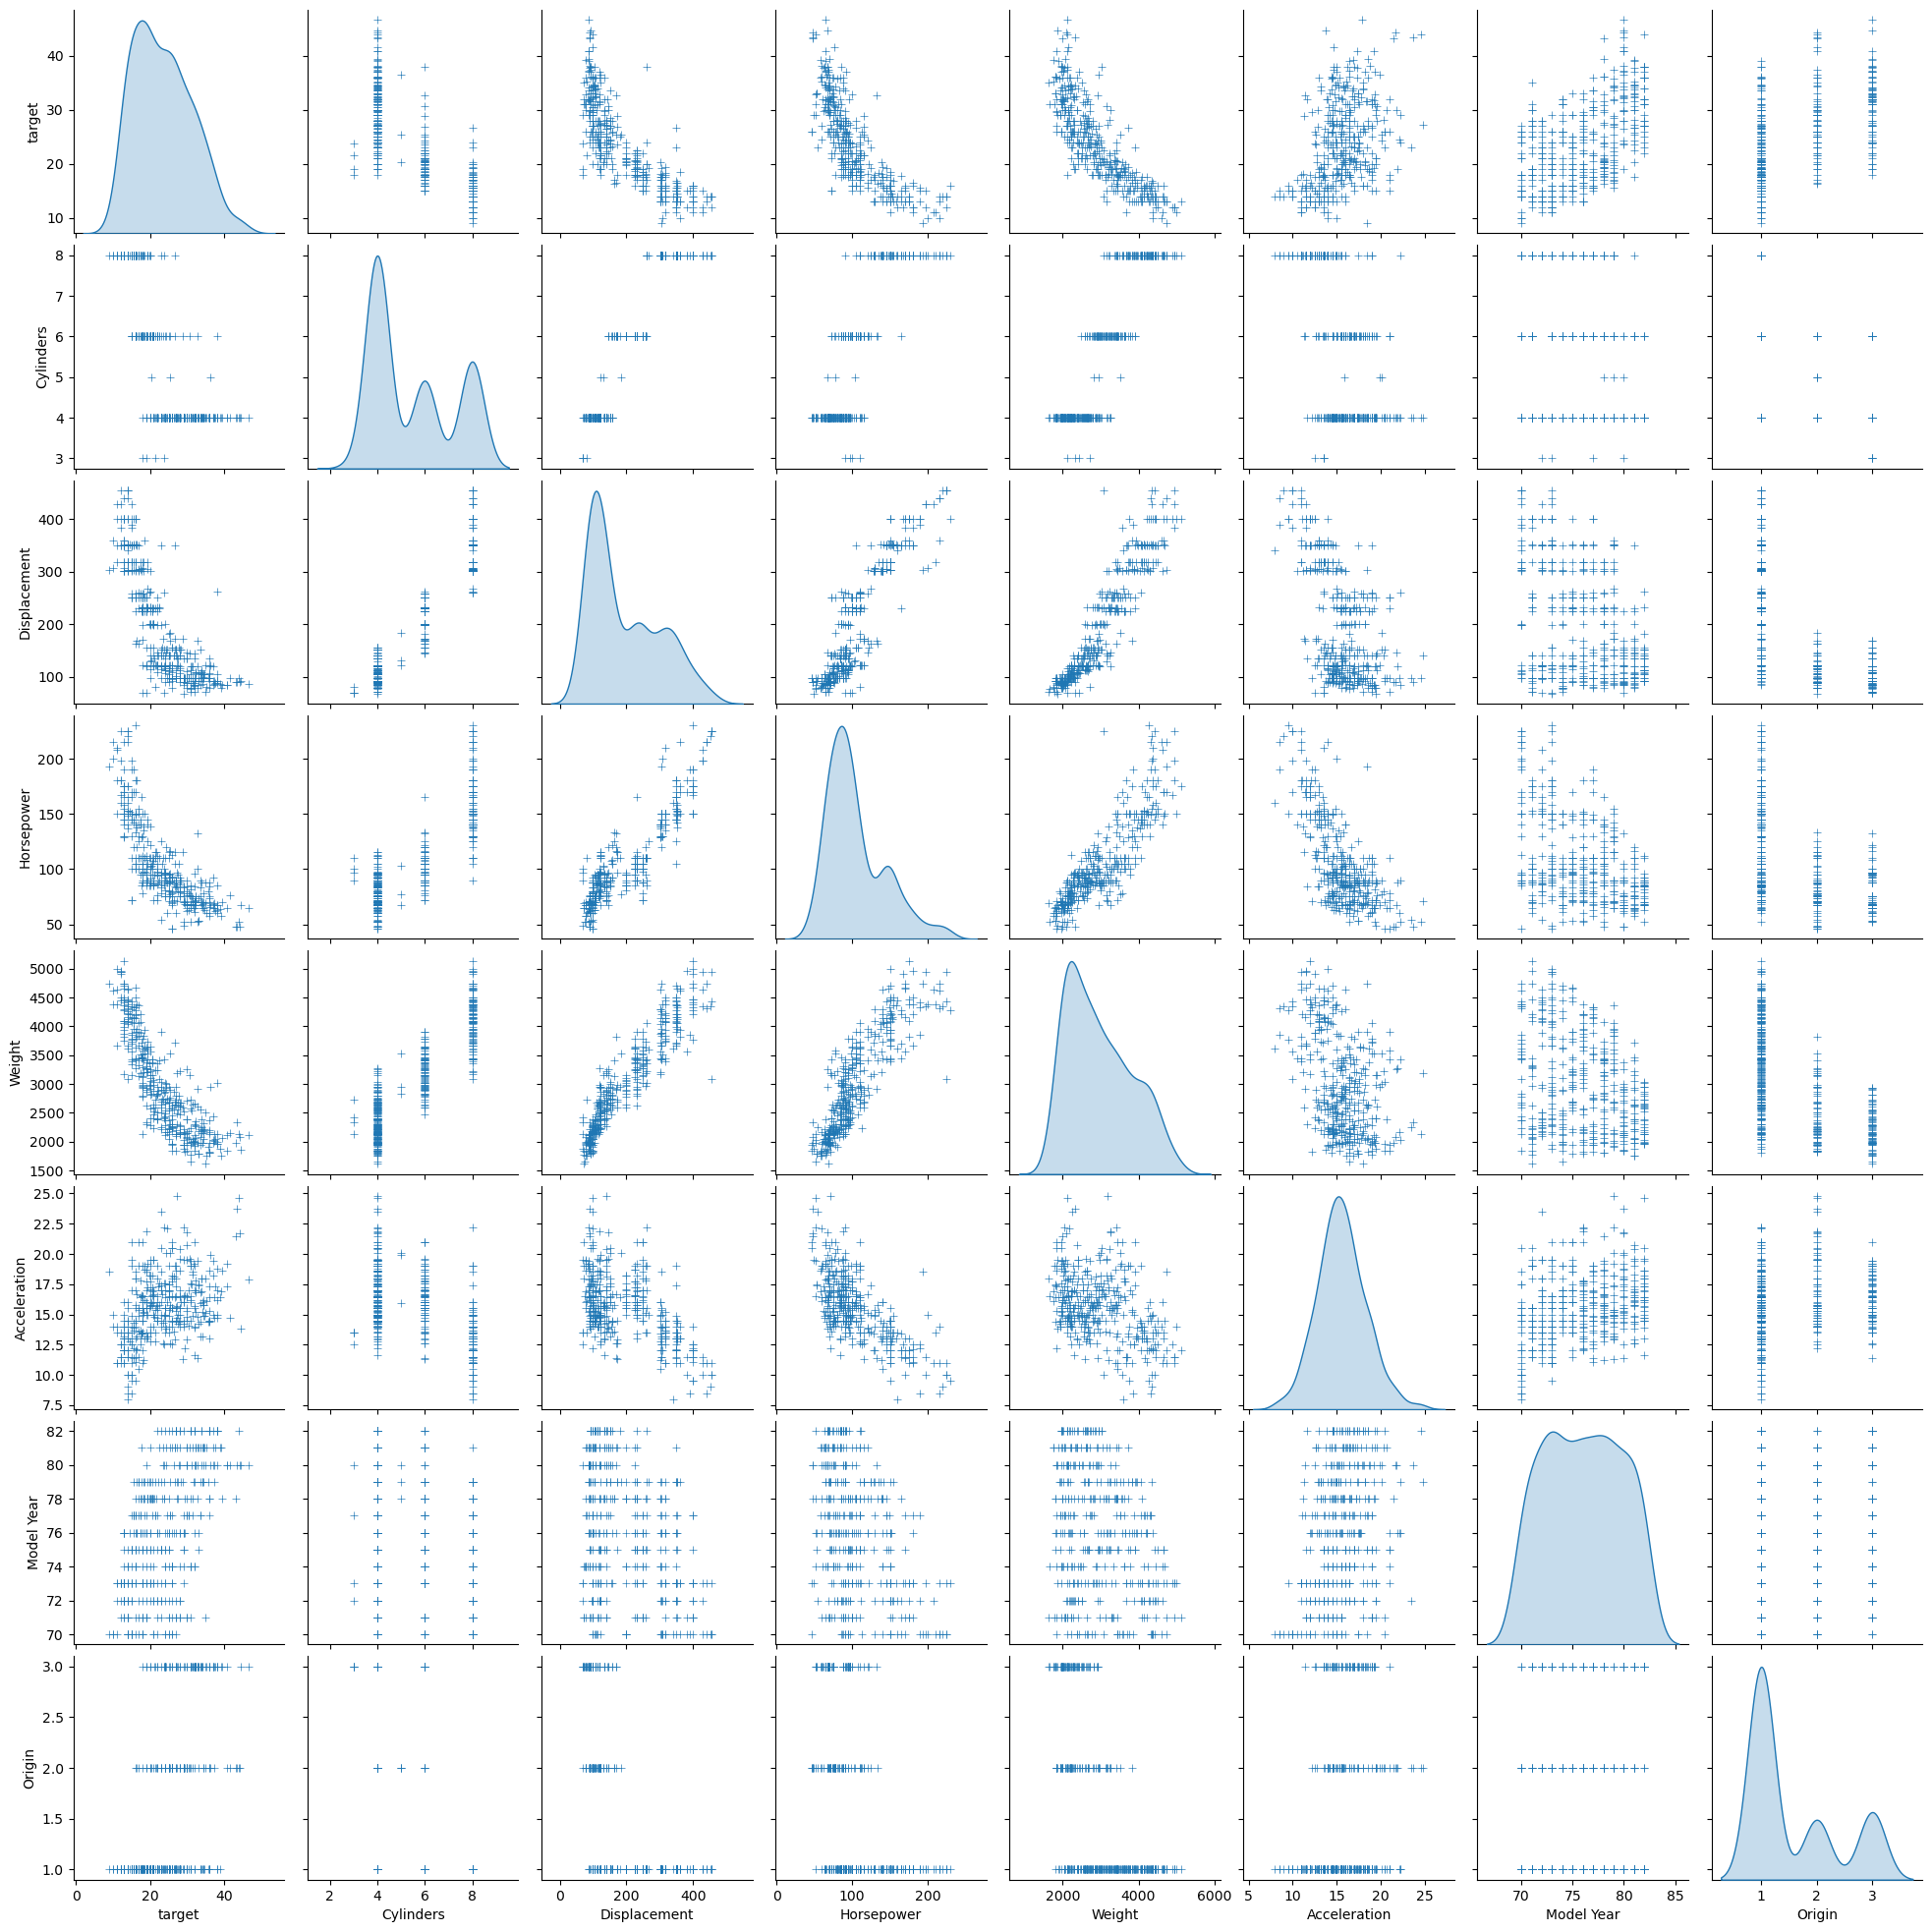

In [150]:
sns.pairplot(data,diag_kind="kde",markers="+")
plt.show()

* The target feature has positive skewness.
* When the relationship between the cylinder feature and the target feature is examined, it is seen that the cylinder feature can be divided into categories. Therefore, the cylinder feature can be used in the feature extraction process. 
* It was observed that the target feature was inversely proportional to the weight, horsepower and displacement features.
* The origin feature can be considered as categorical data, like the cylinder feature.
* It was observed that there was no direct relationship between acceleration and target.

Cylinders
4    204
8    103
6     84
3      4
5      3
Name: count, dtype: int64

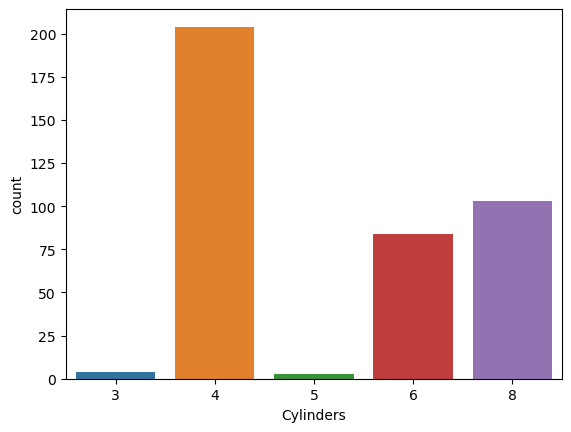

In [151]:
plt.figure()
sns.countplot(x=data["Cylinders"])
data["Cylinders"].value_counts()

Origin
1    249
3     79
2     70
Name: count, dtype: int64

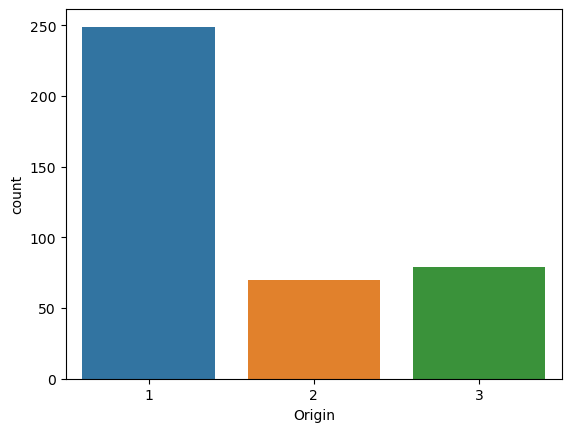

In [152]:
plt.figure()
sns.countplot(x=data["Origin"])
data["Origin"].value_counts()

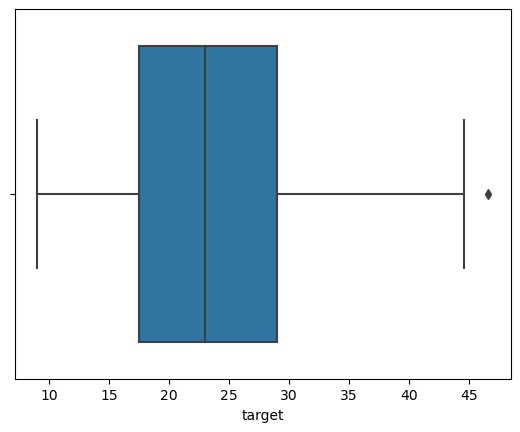

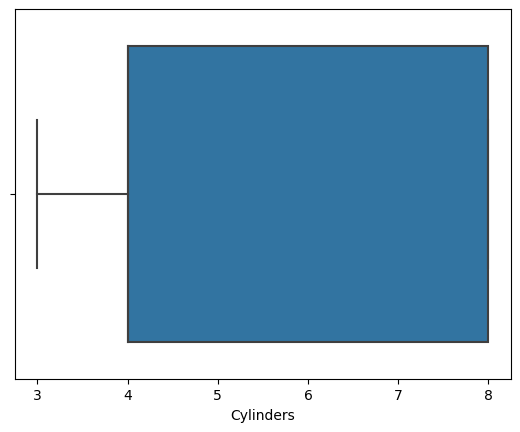

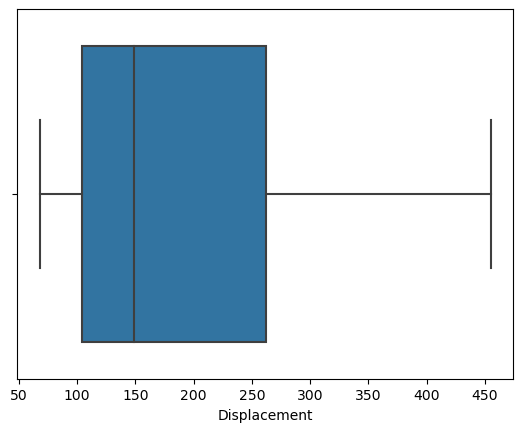

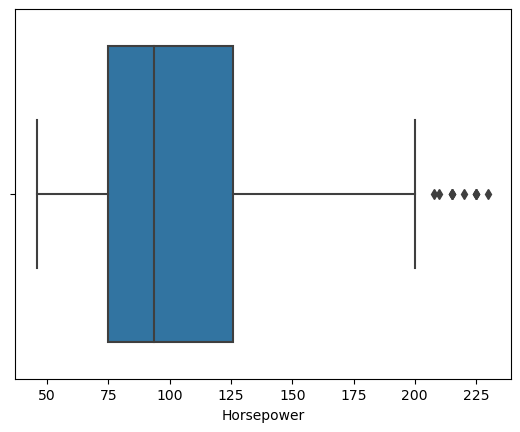

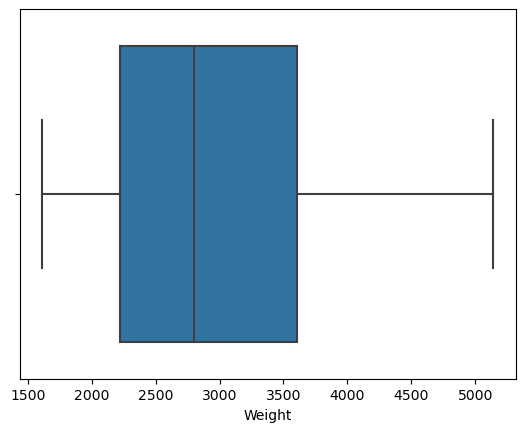

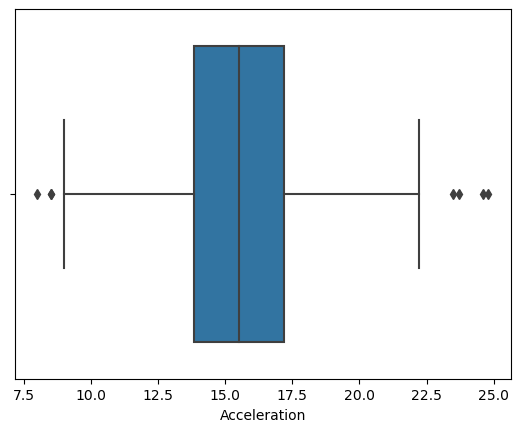

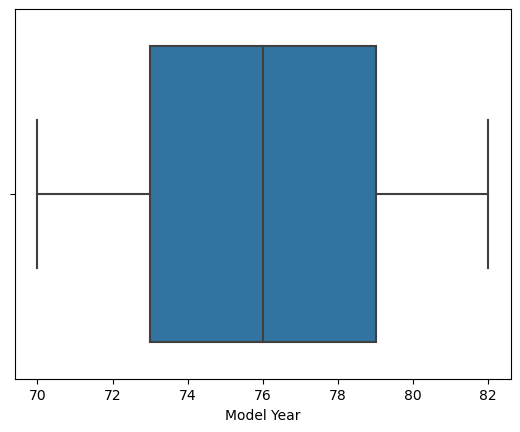

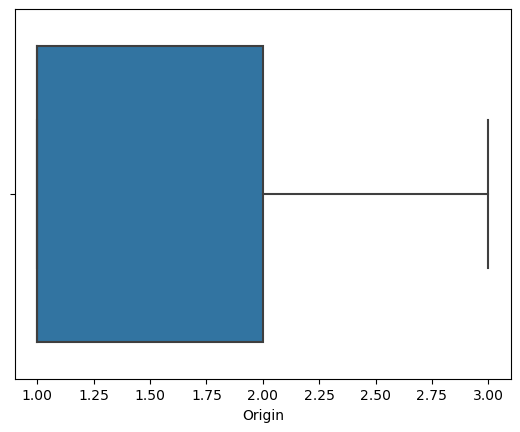

In [153]:
#boxplot
for c in data.columns:
    plt.figure()
    sns.boxplot(x=c,data=data,orient="v")

* Acceleration and horsepower have outliers.

In [154]:
data.shape

(398, 8)

In [155]:
threshold=2
horsepower_desc=data.Horsepower.describe()
q3_hp=horsepower_desc[6]
q1_hp=horsepower_desc[4]
IQR_hp=q3_hp-q1_hp
top_limit_hp=q3_hp+threshold*IQR_hp
bottom_limit_hp=q1_hp-threshold*IQR_hp
filter_hp_bottom=bottom_limit_hp<data['Horsepower']
filter_hp_top=top_limit_hp>data['Horsepower']
filter_hp=filter_hp_bottom&filter_hp_top
data=data[filter_hp]

In [156]:
data.shape

(391, 8)

In [157]:
acceleration_desc=data.Acceleration.describe()
q3_acc=acceleration_desc[6]
q1_acc=acceleration_desc[4]
IQR_acc=q3_acc-q1_acc
top_limit_acc=q3_acc+threshold*IQR_acc
bottom_limit_acc=q1_acc-threshold*IQR_acc
filter_acc_bottom=bottom_limit_acc<data['Acceleration']
filter_acc_top=top_limit_acc>data['Acceleration']
filter_acc=filter_acc_bottom&filter_acc_top
data=data[filter_acc]

In [158]:
data.shape

(388, 8)

## Feature Engineering
### Skewness

<Axes: xlabel='target', ylabel='Density'>

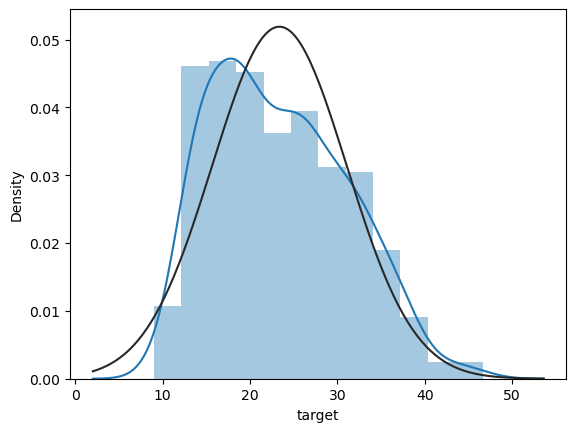

In [159]:
# Target dependent Variable
sns.distplot(data.target,fit=norm)

In [160]:
(mu,sigma)=norm.fit(data["target"])
print("mu: {}, sigma:{}".format(mu,sigma))

mu: 23.351030927835048, sigma:7.68673539280776


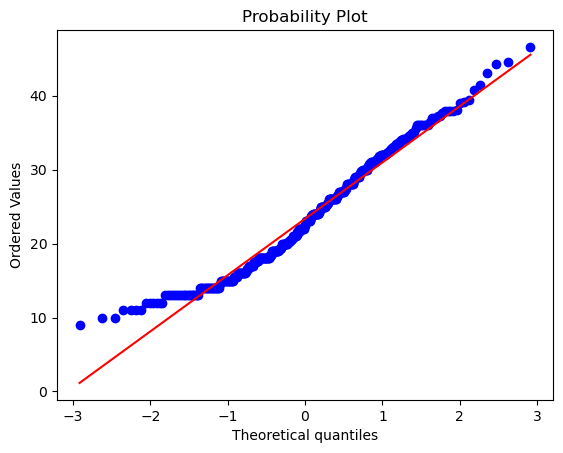

In [161]:
#qq plot
plt.figure()
stats.probplot(data["target"],plot=plt)
plt.show()

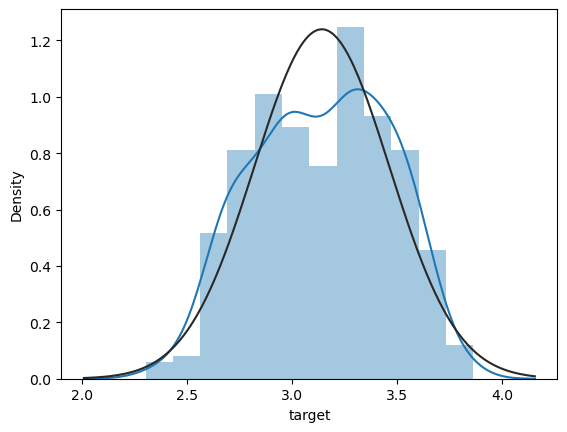

In [162]:
data["target"]=np.log1p(data["target"])
plt.figure()
sns.distplot(data.target,fit=norm)
plt.show()

In [163]:
(mu,sigma)=norm.fit(data["target"])
print("mu: {}, sigma:{}".format(mu,sigma))

mu: 3.141827977294868, sigma:0.3217858281062636


#qq plot
plt.figure()
stats.probplot(data["target"],plot=plt)
plt.show()

In [164]:
#feature - independent variable

skewed_feat=data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness=pd.DataFrame(skewed_feat, columns=["skewed"])

In [165]:
skewness

,skewed
Horsepower,1.064453
Origin,0.918179
Displacement,0.693264
Weight,0.517473
Cylinders,0.500248
Acceleration,0.133013
Model Year,0.026347
target,-0.120265


* Only the skewness value of the horsepower feature is greater than 1. Since it is also negligible, box-cox transformation was not required.

In [166]:
# One Hot Encoding

data["Cylinders"]=data["Cylinders"].astype(str)
data["Origin"]=data["Origin"].astype(str)
data=pd.get_dummies(data)

In [167]:
data

,target,Displacement,Horsepower,Weight,Acceleration,Model Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,130.0,3504.0,12.0,70,False,False,False,False,True,True,False,False
1,2.772589,350.0,165.0,3693.0,11.5,70,False,False,False,False,True,True,False,False
2,2.944439,318.0,150.0,3436.0,11.0,70,False,False,False,False,True,True,False,False
3,2.833213,304.0,150.0,3433.0,12.0,70,False,False,False,False,True,True,False,False
4,2.890372,302.0,140.0,3449.0,10.5,70,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,3.332205,151.0,90.0,2950.0,17.3,82,False,True,False,False,False,True,False,False
393,3.332205,140.0,86.0,2790.0,15.6,82,False,True,False,False,False,True,False,False
395,3.496508,135.0,84.0,2295.0,11.6,82,False,True,False,False,False,True,False,False
396,3.367296,120.0,79.0,2625.0,18.6,82,False,True,False,False,False,True,False,False


## Train/Test Split and Standardization

In [168]:
X=data.drop(["target"],axis=1)
y=data.target

In [169]:
test_size=0.9
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=test_size,random_state=42)

In [170]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## Regression Models

In [171]:
# Linear Regression
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [172]:
lr.coef_

array([-1.46998954e-01, -4.15377891e-02, -1.03642644e-01, -3.12289768e-02,
        1.06414746e-01, -1.04083409e-17, -2.58145648e-02, -4.16333634e-17,
        3.53746532e-03,  3.58878528e-02,  6.42760836e-05,  9.82979113e-03,
       -9.90977256e-03])

In [173]:
y_predicted_dummy=lr.predict(X_test)

In [174]:
mse=mean_squared_error(y_test,y_predicted_dummy)
print("Linear Regression MSE: {}".format(mse))

Linear Regression MSE: 0.018115404918955632


Ridge Coef:  [-0.12112959 -0.03673827 -0.10890635 -0.02889411  0.10436398  0.
 -0.01322679  0.         -0.00083298  0.02229756 -0.00100047  0.00947107
 -0.00822614]
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.016646690091682518
--------------------------------------------------------------------


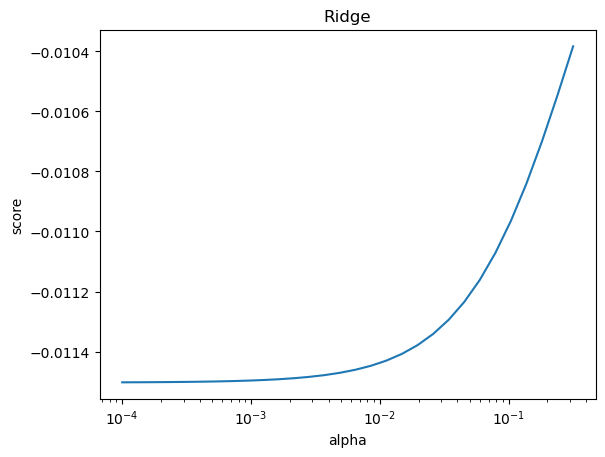

In [175]:
# Ridge Regression (L2)
ridge=Ridge(random_state=42,max_iter=10000)
alphas=np.logspace(-4,-0.5,30)
tuned_parameters=[{'alpha':alphas}]
n_folds=5

clf=GridSearchCV(ridge,tuned_parameters,cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(X_train,y_train)
scores=clf.cv_results_["mean_test_score"]
scores_std=clf.cv_results_["std_test_score"]
print("Ridge Coef: ",clf.best_estimator_.coef_)
ridge=clf.best_estimator_
print("Ridge Best Estimator: ",ridge)
y_predicted_dummy=clf.predict(X_test)
mse=mean_squared_error(y_test,y_predicted_dummy)
print("Ridge MSE: ",mse)
print("--------------------------------------------------------------------")
plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")
plt.show()

Lasso Coef:  [-0.06943716 -0.         -0.13914854 -0.          0.09143367  0.
  0.01701838  0.         -0.         -0.         -0.          0.
 -0.        ]
Lasso Best Estimator:  Lasso(alpha=0.011264816923358867, max_iter=10000, random_state=42)
Lasso MSE:  0.014277682374941215
--------------------------------------------------------------------


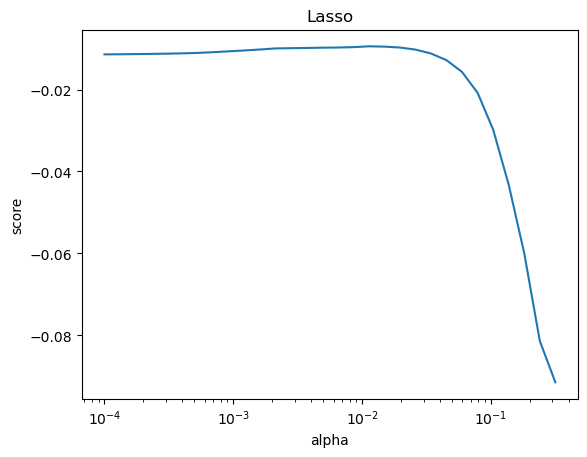

In [176]:
# Lasso Regression

lasso=Lasso(random_state=42,max_iter=10000)
alphas=np.logspace(-4,-0.5,30)
tuned_parameters=[{'alpha':alphas}]
n_folds=5

clf=GridSearchCV(lasso,tuned_parameters,cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(X_train,y_train)
scores=clf.cv_results_["mean_test_score"]
scores_std=clf.cv_results_["std_test_score"]
print("Lasso Coef: ",clf.best_estimator_.coef_)

lasso=clf.best_estimator_
print("Lasso Best Estimator: ",lasso)

y_predicted_dummy=clf.predict(X_test)
mse=mean_squared_error(y_test,y_predicted_dummy)
print("Lasso MSE: ",mse)

print("--------------------------------------------------------------------")

plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")
plt.show()

In [177]:
# ElasticNet

eNet=ElasticNet(random_state=42,max_iter=10000)
alphas=np.logspace(-4,-0.5,30)
tuned_parameters=[{'alpha':alphas,"l1_ratio":np.arange(0.0,1.0,0.05)}]


clf=GridSearchCV(eNet,tuned_parameters,cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(X_train,y_train)
scores=clf.cv_results_["mean_test_score"]
scores_std=clf.cv_results_["std_test_score"]
print("ElasticNet Coef: ",clf.best_estimator_.coef_)

eNet=clf.best_estimator_
print("ElasticNet Best Estimator: ",eNet)

y_predicted_dummy=clf.predict(X_test)
mse=mean_squared_error(y_test,y_predicted_dummy)
print("ElasticNet MSE: ",mse)
print("--------------------------------------------------------------------")

ElasticNet Coef:  [-0.07237522 -0.         -0.13392232 -0.          0.09038825  0.
  0.01849553  0.         -0.         -0.         -0.          0.
  0.        ]
ElasticNet Best Estimator:  ElasticNet(alpha=0.0196382800192977, l1_ratio=0.6000000000000001,
           max_iter=10000, random_state=42)
ElasticNet MSE:  0.014317631166426764
--------------------------------------------------------------------


In [178]:
# XGBoost
parametersGrid={'nthread':[4],
               'objective':['reg:linear'],
               'learning_rate':[.03,.05,.07],
               'max_depth':[5,6,7],
               'min_child_weight':[4],
               'silent':[1],
               'subsample':[0.07],
               'colsample_bytree':[0.07],
               'n_estimators':[500,1000]}

model_xgb=xgb.XGBRFRegressor()

clf=GridSearchCV(model_xgb,parametersGrid,cv=n_folds,scoring='neg_mean_squared_error',refit=True,n_jobs=5,verbose=True)
clf.fit(X_train,y_train)
model_xgb=clf.best_estimator_
y_predicted_dummy=clf.predict(X_test)
mse=mean_squared_error(y_test,y_predicted_dummy)
print("XGBRegressor MSE: ",mse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
XGBRegressor MSE:  0.11025074634948374


In [179]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)  

In [180]:
averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(X_train, y_train)

y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(y_test,y_predicted_dummy)
print("Averaged Models MSE: ",mse)

Averaged Models MSE:  0.036990557022628996


## Conclusion

* Linear Regression MSE:  0.018115404918955632
* Ridge MSE:  0.016646690091682518
* Lasso MSE:  0.014277682374941215
* ElasticNet MSE:  0.014317631166426764
* XGBRegressor MSE: 0.11025074634948374
* Averaged Models (XGBoost and Lasso) MSE: 0.016034769734972223